# Multi-Objective Optimization Example

In [1]:
# I used the official pymoo website as reference for this code:
# https://pymoo.org/index.html

import autograd.numpy as anp
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

class MyProblem(Problem):
  def __init__(self):
    super().__init__(n_var=2,
                     n_obj=2,
                     n_ieq_constr=2,
                     xl=anp.array([-2,-2]),
                     xu=anp.array([2,2]))
  
  def _evaluate(self, x, out, *args, **kwargs):
    f1 = x[:,0]**2 + x[:,1]**2
    f2 = (x[:,0]-1)**2 + x[:,1]**2
    
    g1 = 2*(x[:,0]-0.1) * (x[:,0]-0.9) / 0.18
    g2 = -20*(x[:,0]-0.4) * (x[:,0]-0.6) / 4.8

    f = anp.column_stack([f1, f2])
    g = anp.column_stack([g1, g2])

    # print('x', x)
    # print('f', f)
    # print('g', g)
    
    out["F"] = f
    out["G"] = g
    
problem = MyProblem()

algorithm = NSGA2(
  pop_size=5, #50
  n_offsprings=10,
  sampling=FloatRandomSampling(),
  crossover=SBX(prob=0.9, eta=15),
  mutation=PM(eta=20),
  eliminate_duplicates=True
)

termination = get_termination("n_gen", 40) #40

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        5 |      1 |  5.9119727161 |  3.047243E+01 |             - |             -
     2 |       15 |      1 |  4.3356956015 |  5.6258314577 |             - |             -
     3 |       25 |      1 |  0.000000E+00 |  3.7442775651 |             - |             -
     4 |       35 |      1 |  0.000000E+00 |  0.000000E+00 |  0.2930742739 |         ideal
     5 |       45 |      3 |  0.000000E+00 |  0.000000E+00 |  0.5444701018 |         ideal
     6 |       55 |      5 |  0.000000E+00 |  0.000000E+00 |  0.6119993393 |         ideal
     7 |       65 |      2 |  0.000000E+00 |  0.000000E+00 |  0.7067301977 |         ideal
     8 |       75 |      3 |  0.000000E+00 |  0.000000E+00 |  0.7473242941 |         ideal
     9 |       85 |      4 |  0.000000E+00 |  0.000000E+00 |  0.5182800656 |         ideal
    10 |       95 |      5 |  0.000000E+00 |  0.000000E+00 |  0.6922068690 |         ideal

# Visualize

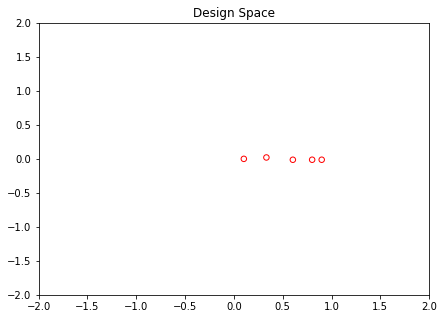

In [3]:
import matplotlib.pyplot as plt

xl, xu = problem.bounds()

plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

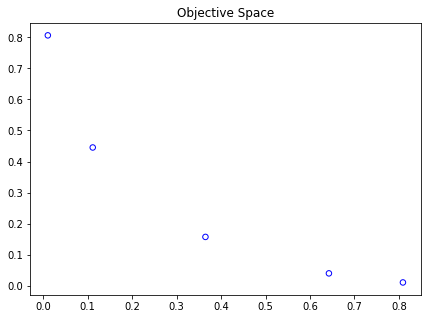

In [4]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [5]:
fl = F.min(axis=0)
fu = F.max(axis=0)

print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

Scale f1: [0.010394778518924319, 0.8090663283786674]
Scale f2: [0.010272074825855198, 0.8064901562229236]


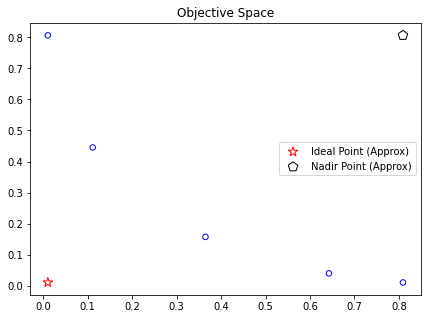

In [6]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()

Scale f1: [0.0, 1.0]
Scale f2: [0.0, 1.0]


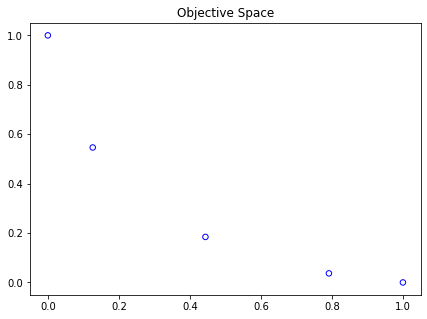

In [7]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

fl = nF.min(axis=0)
fu = nF.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

plt.figure(figsize=(7, 5))
plt.scatter(nF[:, 0], nF[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

# Compromise Programming

Best regarding ASF: Point 
i = 3
F = [0.36491187 0.15701316]


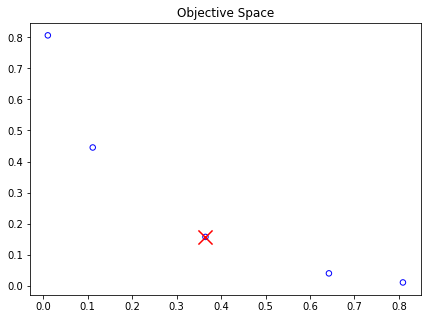

In [8]:
from pymoo.decomposition.asf import ASF

weights = anp.array([0.2, 0.8])
decomp = ASF()
i = decomp.do(nF, 1/weights).argmin()

print("Best regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()

# Pseudo-Weights

Best regarding Pseudo Weights: Point 
i = 4
F = [0.64261171 0.03953894]


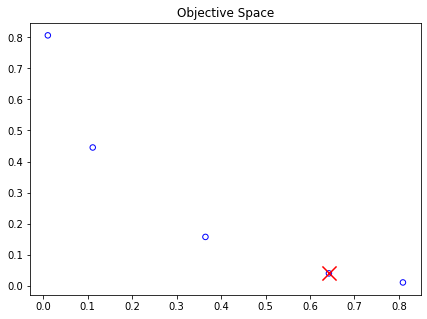

In [9]:
from pymoo.mcdm.pseudo_weights import PseudoWeights

i = PseudoWeights(weights).do(nF)

print("Best regarding Pseudo Weights: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.show()